# pypdfium

In [ ]:
import re
from pprint import pprint
import pypdfium2 as pdfium
import pandas as pd
import numpy as np

pdf_path = "bb_2024_gesamt.pdf"

pdf = pdfium.PdfDocument(pdf_path)
pages_text = []
for i in range(len(pdf)):
    page = pdf[i]
    text = page.get_textpage().get_text_range()
    pages_text.append(text)

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


In [110]:
toc = pages_text[6].split("\r\n")+pages_text[7].split("\r\n")
start_idx = [idx for idx, line in enumerate(toc) if "6. Einzeldarstellung" in line][0]+1
end_idx = [idx for idx, line in enumerate(toc) if "7. Anhang" in line][0]

toc = toc[start_idx:end_idx]
toc = [line.strip() for line in toc if line.strip()]
toc = [re.sub(r"\s?(\.)+\s\d+", "", line) for line in toc]
# Combine entries that end with "-" with the following entry
combined_toc = []
skip_next = False
for i, entry in enumerate(toc):
    if skip_next:
        skip_next = False
        continue
    if entry.endswith("-") and i + 1 < len(toc):
        combined_toc.append(entry + " " + toc[i + 1])
        skip_next = True
    else:
        combined_toc.append(entry)
toc = combined_toc
[{"title": company, "nr": idx, "page": page_numbers[idx]} for idx, company in enumerate(toc)]

[{'title': 'Amt für Statistik Berlin-Brandenburg Anstalt des öffentlichen Rechts',
  'nr': 0,
  'page': 34},
 {'title': 'BBB Infrastruktur GmbH & Co. KG', 'nr': 1, 'page': 37},
 {'title': 'BBB Infrastruktur-Verwaltungs GmbH', 'nr': 2, 'page': 41},
 {'title': 'BEHALA - Berliner Hafen- und Lagerhausgesellschaft mbH',
  'nr': 3,
  'page': 44},
 {'title': 'BEN Berlin Energie und Netzholding GmbH', 'nr': 4, 'page': 48},
 {'title': 'Berlin Tourismus & Kongress GmbH', 'nr': 5, 'page': 51},
 {'title': 'Berliner Bäder-Betriebe (BBB) Anstalt des öffentlichen Rechts',
  'nr': 6,
  'page': 55},
 {'title': 'Berliner Energieagentur Gesellschaft mit beschränkter Haftung',
  'nr': 7,
  'page': 59},
 {'title': 'Berliner Großmarkt GmbH', 'nr': 8, 'page': 63},
 {'title': 'Berliner Stadtgüter GmbH', 'nr': 9, 'page': 67},
 {'title': 'Berliner Stadtreinigungsbetriebe (BSR) Anstalt des öffentlichen Rechts',
  'nr': 10,
  'page': 71},
 {'title': 'Berliner Verkehrsbetriebe (BVG) Anstalt des öffentlichen Rechts

In [27]:
pages_of_interest = [{'text': page_text, 'page_number': i} for i, page_text in enumerate(pages_text) if 'Wirtschaftsdaten (in Mio. €)' in page_text]
for idx, entry in enumerate(toc):
        pages_of_interest[idx]['company'] = entry

In [28]:
page_numbers = [page['page_number'] for page in pages_of_interest]
print(f"Pages of interest: {page_numbers}")

Pages of interest: [34, 37, 41, 44, 48, 51, 55, 59, 63, 67, 71, 75, 79, 83, 89, 93, 96, 100, 104, 108, 112, 116, 120, 124, 128, 131, 134, 138, 142, 147, 151, 154, 158, 162, 166, 169, 173, 177, 181, 185, 189, 191, 194, 198, 201, 205, 209, 212, 216, 219, 223, 227, 231, 235, 240, 244, 248, 252, 256, 260]


In [405]:
# pprint(pages_of_interest[1])

In [406]:
def extract_numbers(text):
    text = re.sub(r'(-?(?:\d+\.?\d*),?(\d*))', r' \1', text) # seperate numbers with spaces
    text = text.replace('CO 2-', 'COO_')  # replace line breaks with spaces
    # pprint(text)
    # Only match spaces that are not preceded by \r or \n
    pattern = r'((?:-?[a-zA-ZäöüÄÖÜß²³ /\.\(\)%€_,]+-?[a-zA-ZäöüÄÖÜß² /\.\(\)%€_]+)(?:(?:[^\r\n]\s*-?[\.\d]+(?:,[\d]+)?)|(?:\s---)){1,})'
    matches = []
    for match in re.findall(pattern, text):
        s = match
        # print(s)
        # Split before every number or '---'
        split_parts = re.split(r'(?=\s+-?(?:\d+\.?\d*)(?:,[\d]+)?)|(?=\s---)', s)
        matches.append([part.strip() for part in split_parts if part.strip()])
    matches = [m for m in matches if len(m) > 1]  # Filter out single-item lists
    return matches

# pprint(extract_numbers(pages_of_interest[0]['text']))

In [407]:
# pd.DataFrame(extract_numbers(pages_of_interest[55]['text']))

In [408]:
matches_reference = extract_numbers(pages_of_interest[0]['text'])
# pprint(matches_reference)

In [409]:
common_row_names = [entry[0] for entry in matches_reference[1:37]]
# common_row_names

In [290]:
import re

page = [page['text'] for page in pages_of_interest if page['page_number'] == 37][0]
# Insert a space before every number (integer or float, with ',' as decimal separator)
page_with_spaces = re.sub(r'(-?(\d+),?(\d*))', r' \1', page)
# pprint(page_with_spaces)

In [291]:
import numpy as np

def check_extraction(matches, show_missing_rows=False, show_additional_rows=False, show_irregular_rows=False):
    n_cols = int(np.median([len(row) for row in matches]))
    # print(n_cols)
    long_rows = [row for row in matches if len(row) > n_cols]
    short_rows = [row for row in matches if len(row) < n_cols]
    
    if long_rows and show_irregular_rows:
        print(f"Long rows found on page {entry['page_number']}:")
        pprint(long_rows)
    if short_rows and show_irregular_rows:
        print(f"Short rows found on page {entry['page_number']}:")
        pprint(short_rows)

    # print(matches)
    row_names = [entry[0] for entry in matches]
    # print(len(row_names))

    missing_rows = set(common_row_names).difference(set(row_names))
    if missing_rows and show_missing_rows:
        print(f"Missing in row: {missing_rows}")

    last_regular_index = [idx for idx, row_name in enumerate(row_names) if row_name == 'Personalkostenquote (%)'][0]
    # print(f"Last regular index: {last_regular_index}")

    additional_rows = set(row_names[1:last_regular_index+1]).difference(set(common_row_names))
    if additional_rows and show_additional_rows:
        print(f"Additional in row: {additional_rows}")

for idx, entry in enumerate(pages_of_interest[:]):
    print(f"Processing page {entry['page_number']}, entry {idx}")
    # print(entry['text'][:100])
    matches = extract_numbers(entry['text'])
    check_extraction(matches, show_missing_rows=True, show_additional_rows=True, show_irregular_rows=True)

Processing page 34, entry 0
Processing page 37, entry 1
Processing page 41, entry 2
Short rows found on page 41:
[['Beschäftigte', '22222']]
Processing page 44, entry 3
Processing page 48, entry 4
Processing page 51, entry 5
Processing page 55, entry 6
Processing page 59, entry 7
Processing page 63, entry 8
Processing page 67, entry 9
Processing page 71, entry 10
Processing page 75, entry 11
Processing page 79, entry 12
Processing page 83, entry 13
Processing page 89, entry 14
Missing in row: {'- Sonderposten für Zuschüsse'}
Processing page 93, entry 15
Short rows found on page 93:
[['Beschäftigte', '33333']]
Processing page 96, entry 16
Short rows found on page 96:
[['Beschäftigte', '99988']]
Processing page 100, entry 17
Processing page 104, entry 18
Processing page 108, entry 19
Processing page 112, entry 20
Processing page 116, entry 21
Short rows found on page 116:
[['Neuaufnahme Student/innen (Anz.)', '31', '29', '320', '32'],
 ['Studienabbrüche (Anz.)', '12220']]
Processing page

# tabula

In [308]:
import tabula as tb
import numpy as np
import pandas as pd

df_list = []

for p_no in page_numbers[:]:
    df = tb.read_pdf(
        pdf_path, 
        pages=p_no+1,
        area=(67.346, 53.132, 806.287, 550.225), 
        columns=[247, 300, 355, 415, 470],
        output_format='dataframe', 
        multiple_tables=False, 
        stream=True,
        guess=False,
        pandas_options={'dtype': str, 'header': None},
        # pandas_options={'keep_default_na': False, 'na_filter': False}
    )
    df_list.append(df[0])

In [410]:
for idx, df in enumerate(df_list):
    print(f"Processing DataFrame for page {page_numbers[idx]}")
    rows = df.values.tolist()
    check_extraction(rows, show_missing_rows=True, show_additional_rows=False, show_irregular_rows=False)

Processing DataFrame for page 34
Missing in row: {'- Kreditverbindlichkeiten', '- Rücklagen'}
Processing DataFrame for page 37
Missing in row: {'- Kreditverbindlichkeiten', '- Zinsaufwand', '- Finanzanlagen', '- davon Auszubildende', '- Personalaufwand'}
Processing DataFrame for page 41
Missing in row: {'- Sonderposten für Zuschüsse', '- Kreditverbindlichkeiten', '- Sachanlagen', '- Zinsaufwand', '- Rücklagen', '- Finanzanlagen', '- davon Auszubildende', '- Abschreibungen', '- Zuführungen Land Berlin', '- Personalaufwand', '- Anlagevermögen'}
Processing DataFrame for page 44
Missing in row: {'- Zuführungen Land Berlin'}
Processing DataFrame for page 48
Processing DataFrame for page 51
Missing in row: {'- Rücklagen'}
Processing DataFrame for page 55
Missing in row: {'- Finanzanlagen', '- Kreditverbindlichkeiten', '- Rücklagen', '- Eigenkapital'}
Processing DataFrame for page 59
Missing in row: {'- Zuführungen Land Berlin'}
Processing DataFrame for page 63
Missing in row: {'- Finanzanlag

In [594]:
def combine_rows(data):
    row_list = []
    combined_row_names = []
    df = data.copy()
    row_names = df[df.columns[1]].to_list()
    skip_next = False
    for i, entry in enumerate(row_names):
        if skip_next:
            skip_next = False
            continue
        if i + 1 < len(row_names) and df[df.columns[2:]].iloc[i + 1].isnull().all():
            new_row_name = entry + " " + row_names[i + 1]
            combined_row_names.append(re.sub('- ', '', new_row_name))
            row_list.append(df.iloc[i].to_list())
            skip_next = True
        else:
            combined_row_names.append(entry)
            row_list.append(df.iloc[i].to_list())

    combined_row_names
    df = pd.DataFrame(row_list)
    df[df.columns[1]] = combined_row_names
    df.columns = data.columns
    return df

# combine_rows(df)

def clean_text(t):
    t = t.replace('\x02', '')
    for s in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten', 'Beschäftigte']:
        t = t.replace(s+'\r\n', '')
    t = re.sub(r'([a-zA-ZäöüÄÖÜß /]+-?)\r\n([a-zA-Z ()\.]+)', r'\1\2', t)
    return t

def add_missing_rows(df, idx, verbose=False):
    t = clean_text(pages_of_interest[idx]['text'])
    text_extract = extract_numbers(t)
    text_extract = [row for row in text_extract if row[0] not in ['Bilanzdaten']]  # Exclude 'Bilanzdaten' rows
    text_row_names = [row[0].replace('²', '2') for row in text_extract]

    row_names = df[df.columns[1]]

    missing_rows = list(set(text_row_names).difference(set(row_names)))
    # print(f"Missing rows in DataFrame for page {page_numbers[idx]} ({idx}): {missing_rows}")

    empty_missing_rows = []
    for missing in missing_rows:
        empty_missing_rows += [row[0] for row in text_extract if (row[0] == missing and all(cell == '---' for cell in row[1:]))]
    # print(empty_missing_rows)

    j = 0
    for i, row in df.iterrows():
        row_name = row[df.columns[1]]
        # print(row_name+" vs " + text_row_names[j] + " (" + str(j) + ")")
        if row_name != text_row_names[j]:
            if text_row_names[j] in empty_missing_rows:
                # print(f"Adding missing row: {text_row_names[j]} with text {text_extract[j]}")
                df.loc[df.index[i]-0.5] = [df.loc[i-1, df.columns[0]]] + text_extract[j]
                df.sort_index(inplace=True)
                df.reset_index(drop=True, inplace=True)
                # j += 1
        j += 1        

    non_empty_missing_rows = []
    for missing in missing_rows:
        term = [row[0] for row in text_extract if (row[0] == missing and not all(cell == '---' for cell in row[1:]) and row[0] != 'Bilanzdaten')]
        if term:
            non_empty_missing_rows.append(term[0])
    if non_empty_missing_rows:
        print(f"Relevant missing rows in Dataframe for page {page_numbers[idx]} ({idx}): {non_empty_missing_rows}")

    missing_rows = list(set(row_names).difference(set(text_row_names)))
    missing_rows = [row for row in missing_rows if row not in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten', np.nan]]
    if missing_rows:
        print(f"Missing rows in text extract for page {page_numbers[idx]} ({idx}): {missing_rows}")

        # for missing in missing_rows:
        #     print(df[df[df.columns[1]] == missing].values.tolist())

    return df

def clean_first_column(df):
    non_numeric_mask = df[df.columns[1:]].map(lambda x: bool(re.search(r'[^nan][^\d.,\-]', str(x))))

    # Move non-numeric values in the first data column to the end of the first column
    first_data_col = df.columns[1]
    mask = non_numeric_mask[first_data_col]
    if mask.any():
        for idx_row in df.index[mask]:
            # print(f"Processing row {idx_row} in DataFrame for page {page_numbers[idx]}")
            # Move only the leading non-numeric characters from the first data column to the end of the first column
            value = str(df.at[idx_row, first_data_col])
            match = re.match(r"^([^\d,\-]+)", value)
            if match:
                prefix = match.group(1)
                # print(prefix)
                # Append the prefix to the first column, remove it from the data column
                df.at[idx_row, df.columns[0]] = f"{df.at[idx_row, df.columns[0]]}{prefix}".strip()
                df.at[idx_row, first_data_col] = value[len(prefix):].lstrip()
    
    return df

In [595]:
idx = 9  # Index of the page of interest

def postprocess_dfs(df, idx, verbose=False):
    df = df.dropna(how='all')
    df = clean_first_column(df)
    df.columns = ['H3'] + df.iloc[0][1:].astype(int).to_list()

    year_columns = [col for col in df.columns if str(col).strip().isdigit() and 1900 <= int(col) <= 2100]
    # print(year_columns)

    # Insert a new row at the top with the first column set to the first cell value, others as NaN
    first_col = df.columns[0]
    first_cell = df.iloc[0,0]
    new_row = {col: (first_cell if col == first_col else np.nan) for col in df.columns}
    df = df.copy()
    df.iloc[0] = new_row  # Set the first row to the new row

    # # find top hierarchy entries
    mask = df.drop('H3', axis=1).isna().all(axis=1)
    col_h1 = [entry if bool and entry in ['Bilanzdaten', 'GuV-Daten', 'Beschäftigte', 'Allgemeine Daten', 'Spezifische Daten'] else np.nan for entry, bool in zip(df['H3'], mask)]
    # # Insert new column at position 1 with this value for all rows
    df.insert(0, 'H1', col_h1)
    # Use .loc to avoid SettingWithCopyWarning
    df.loc[:, 'H1'] = df['H1'].ffill()
    df = df[~((df['H1'] == df['H3']) & (df[year_columns].isna().all(axis=1)))]
    df = combine_rows(df)

    # add missing rows
    df = add_missing_rows(df, idx, verbose=verbose)

    # # find second hierarchy entries
    mask = ~df['H3'].str.startswith('-')
    col_h2 = [entry if bool else np.nan for entry, bool in zip(df['H3'], mask)]
    df.insert(1, 'H2', col_h2)
    df['H2'] = df['H2'].ffill()

    # missing value instead of "---"; missing means not applicable for company
    df = df.map(lambda x: np.nan if str(x).startswith('---') else x)

    # Convert the last 5 columns to numeric, using ',' as the decimal separator
    for col in year_columns:
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

postprocess_dfs(df_list[idx], idx, verbose=True)

Relevant missing rows in Dataframe for page 67 (9): ['Erlösauskehr Grundstücksverkäufe (Mio. €)']
Missing rows in text extract for page 67 (9): ['Erlösauskehr Grundstücksverkäufe (Mio.€)']


,H1,H2,H3,2023,2022,2021,2020,2019
0,Bilanzdaten,Bilanzsumme,Bilanzsumme,92.85,90.39,88.86,86.21,81.25
1,Bilanzdaten,Bilanzsumme,- Anlagevermögen,68.55,65.69,64.16,57.38,56.81
2,Bilanzdaten,Bilanzsumme,- Sachanlagen,64.75,62.11,60.10,54.31,53.70
3,Bilanzdaten,Bilanzsumme,- Finanzanlagen,3.63,3.44,3.91,3.00,3.00
4,Bilanzdaten,Bilanzsumme,- Umlaufvermögen,24.28,24.68,24.68,28.80,24.42
5,Bilanzdaten,Bilanzsumme,- Eigenkapital,73.68,70.16,68.23,65.86,64.56
6,Bilanzdaten,Bilanzsumme,- Rücklagen,29.24,29.24,29.19,29.19,29.13
7,Bilanzdaten,Bilanzsumme,- Sonderposten für Zuschüsse,NaN,NaN,NaN,NaN,NaN
8,Bilanzdaten,Bilanzsumme,- Fremdkapital,14.27,14.77,13.81,13.36,11.83
9,Bilanzdaten,Bilanzsumme,- Rückstellungen,9.31,8.74,8.31,8.06,6.71


In [620]:
def process_hierarchy_2_and_3(df):
    df_temp = df[df['H1'] != 'Bilanzdaten'].copy()
    df_temp['H3'] = [str(h3).replace("- ", "") if h3 != h2 else np.nan for h2, h3 in zip(df_temp['H2'], df_temp['H3'])]
    df_temp['H4'] = np.nan  # Placeholder for H4
    df_temp['H5'] = np.nan  # Placeholder for H5

    df = df[df['H1'] == 'Bilanzdaten'].copy()
    col_h5 = [entry.replace("- ", "") if any(x in entry for x in ['Kreditverbindlichkeiten']) else np.nan for entry in df['H3']]
    df['H5'] = col_h5
    df['H5'] = df['H5'].ffill()  # Forward fill H5
    col_h4 = [entry.replace("- ", "") if any(x in entry for x in ['Sachanlagen', 'Finanzanlagen', 'Rücklagen', 'Rückstellungen', 'Verbindlichkeiten']) else np.nan for entry in df['H3']]
    df['H4'] = col_h4
    df['H4'] = df['H4'].ffill()  # Forward fill H4
    col_h3 = [entry.replace("- ", "") if any(x in entry for x in ['Anlagevermögen', 'Umlaufvermögen', 'Eigenkapital', 'Sonderposten für Zuschüsse', 'Fremdkapital']) else np.nan for entry in df['H3']]
    df['H3'] = col_h3
    df['H4'] = [h4 if h3 is np.nan else np.nan for h3, h4 in zip(df['H3'], df['H4'])]  # Remove H4 entries where H3 is NaN
    df['H3'] = df['H3'].ffill()  # Forward fill H3

    # Reorder columns: first all H1...H5, then year columns in descending order
    hierarchy_cols = ['H1', 'H2', 'H3', 'H4', 'H5']
    year_cols = [col for col in df_temp.columns if isinstance(col, int) and 1900 <= col <= 2100]
    year_cols = sorted(year_cols, reverse=True)
    other_cols = [col for col in df_temp.columns if col not in hierarchy_cols + year_cols]

    df = df[hierarchy_cols + year_cols + other_cols]
    df_temp = df_temp[hierarchy_cols + year_cols + other_cols]
    # Concatenate the two DataFrames
    df = pd.concat([df, df_temp], ignore_index=True)

    return df

df_temp = process_hierarchy_2_and_3(df_list_copy[56])
df_temp

,H1,H2,H3,H4,H5,2023,2022,2021,2020,2019
0,Bilanzdaten,Bilanzsumme,NaN,NaN,NaN,2425.86,2290.21,2224.35,2116.67,2049.08
1,Bilanzdaten,Bilanzsumme,Anlagevermögen,NaN,NaN,2210.00,2133.09,2052.91,1925.94,1871.00
2,Bilanzdaten,Bilanzsumme,Anlagevermögen,Sachanlagen,NaN,2160.95,2084.17,2003.89,1883.81,1829.00
3,Bilanzdaten,Bilanzsumme,Anlagevermögen,Finanzanlagen,NaN,48.86,48.53,48.47,41.58,41.19
4,Bilanzdaten,Bilanzsumme,Umlaufvermögen,NaN,NaN,170.75,112.46,121.08,137.73,133.99
5,Bilanzdaten,Bilanzsumme,Eigenkapital,NaN,NaN,919.29,882.44,832.08,793.27,762.33
6,Bilanzdaten,Bilanzsumme,Eigenkapital,Rücklagen,NaN,417.81,417.81,401.49,401.49,394.63
7,Bilanzdaten,Bilanzsumme,Sonderposten für Zuschüsse,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Bilanzdaten,Bilanzsumme,Fremdkapital,NaN,NaN,1486.89,1389.18,1372.76,1304.28,1267.81
9,Bilanzdaten,Bilanzsumme,Fremdkapital,Rückstellungen,NaN,61.32,48.28,30.47,41.00,34.20


In [629]:
df_temp[
    (df_temp['H2'] == 'Bilanzsumme') &
    (df_temp['H3'].notna()) &
    (df_temp['H4'].isna())
    ].agg({
        2023: 'sum'
    })

2023    4786.93
dtype: float64

In [ ]:
import copy

df_list_copy = copy.deepcopy(df_list)
for idx, df in enumerate(df_list_copy[:]):
    print(f"Processing DataFrame for page {page_numbers[idx]} ({idx})")

    df_list_copy[idx] = process_hierarchy_2_and_3(postprocess_dfs(df, idx))

Processing DataFrame for page 34 (0)
Processing DataFrame for page 37 (1)
Processing DataFrame for page 41 (2)
Processing DataFrame for page 44 (3)
Processing DataFrame for page 48 (4)
Processing DataFrame for page 51 (5)
Processing DataFrame for page 55 (6)
Processing DataFrame for page 59 (7)
Processing DataFrame for page 63 (8)
Processing DataFrame for page 67 (9)
Relevant missing rows in Dataframe for page 67 (9): ['Erlösauskehr Grundstücksverkäufe (Mio. €)']
Missing rows in text extract for page 67 (9): ['Erlösauskehr Grundstücksverkäufe (Mio.€)']
Processing DataFrame for page 71 (10)
Processing DataFrame for page 75 (11)
Relevant missing rows in Dataframe for page 75 (11): ['-Bahnlinien, tagsüber (Anz.)']
Missing rows in text extract for page 75 (11): ['U-Bahnlinien, tagsüber (Anz.)']
Processing DataFrame for page 79 (12)
Relevant missing rows in Dataframe for page 79 (12): ['COO_Vermeidung der BSW (kumuliert) (T t)', 'Abwasserreinigung (Mio. m³)', 'Gesamtlänge Trink- und Abwasse

In [631]:
df_list_copy[0]

,H1,H2,H3,H4,H5,2023,2022,2021,2020,2019
0,Bilanzdaten,Bilanzsumme,NaN,NaN,NaN,28.16,29.07,28.41,20.97,15.30
1,Bilanzdaten,Bilanzsumme,Anlagevermögen,NaN,NaN,11.83,12.19,11.74,9.80,7.67
2,Bilanzdaten,Bilanzsumme,Anlagevermögen,Sachanlagen,NaN,0.20,0.29,0.44,0.47,0.48
3,Bilanzdaten,Bilanzsumme,Anlagevermögen,Finanzanlagen,NaN,11.40,11.40,10.70,9.00,7.00
4,Bilanzdaten,Bilanzsumme,Umlaufvermögen,NaN,NaN,15.83,16.42,16.33,10.72,7.29
5,Bilanzdaten,Bilanzsumme,Eigenkapital,NaN,NaN,1.81,2.62,1.67,1.08,1.32
6,Bilanzdaten,Bilanzsumme,Eigenkapital,Rücklagen,NaN,NaN,NaN,NaN,NaN,NaN
7,Bilanzdaten,Bilanzsumme,Sonderposten für Zuschüsse,NaN,NaN,0.43,0.79,1.04,0.58,0.67
8,Bilanzdaten,Bilanzsumme,Fremdkapital,NaN,NaN,25.89,25.61,25.64,19.29,13.31
9,Bilanzdaten,Bilanzsumme,Fremdkapital,Rückstellungen,NaN,17.24,15.49,13.40,12.20,10.79


In [295]:

df1 = pd.DataFrame(extract_numbers(pages_of_interest[0]['text']))
df2 = df_list_copy[0]
df2.columns = [0, 1, 2, 3, 4, 5]

text_extract = extract_numbers(pages_of_interest[0]['text'])
text_row_names = [row[0] for row in text_extract]

row_names = df2[df2.columns[0]]

missing_rows = list(set(text_row_names).difference(set(row_names)))
print(f"Missing rows in DataFrame for page {page_numbers[0]}: {missing_rows}")

for missing in missing_rows:
    print([row for row in text_extract if row[0] == missing])

missing_rows = list(set(row_names).difference(set(text_row_names)))
missing_rows = [row for row in missing_rows if row not in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten', np.nan]]
print(f"Missing rows in text extract for page {page_numbers[0]}: {missing_rows}")

for missing in missing_rows:
    print([row for row in text_extract if row[0] == missing])

Missing rows in DataFrame for page 34: ['- Kreditverbindlichkeiten', '- Rücklagen']
[['- Kreditverbindlichkeiten', '---', '---', '---', '---', '---']]
[['- Rücklagen', '---', '---', '---', '---', '---']]
Missing rows in text extract for page 34: []


In [413]:
t =  pages_of_interest[3]['text']
for s in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten']:
    t = t.replace(s+'\r\n', '')
# pprint(t)

In [414]:
t = re.sub('([a-zA-Z ]+)\r\n([a-zA-Z \()]+)', r'\1\2', t)
# pprint(t)

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_5753/1794546760.py:1: SyntaxWarning: invalid escape sequence '\('
  t = re.sub('([a-zA-Z ]+)\r\n([a-zA-Z \()]+)', r'\1\2', t)


In [415]:
# pprint(extract_numbers(t))

In [ ]:
for idx, df in enumerate(df_list_copy):
    df = df.dropna(how='all')  # Drop rows where all elements are NaN
    df = combine_rows(df)  # Combine rows multiline names
    # print(f"Processing DataFrame for page {page_numbers[idx]} ({idx})")
    t =  pages_of_interest[idx]['text'].replace('\x02', '')
    for s in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten', 'Beschäftigte']:
        t = t.replace(s+'\r\n', '')
    t = re.sub(r'([a-zA-ZäöüÄÖÜß /]+-?)\r\n([a-zA-Z ()\.]+)', r'\1\2', t)

    text_extract = extract_numbers(t)
    text_row_names = [row[0].replace('²', '2') for row in text_extract]

    row_names = df[df.columns[0]]

    missing_rows = list(set(text_row_names).difference(set(row_names)))
    print(f"Missing rows in DataFrame for page {page_numbers[idx]} ({idx}): {missing_rows}")

    for missing in missing_rows:
        non_empty_missing_rows = [row for row in text_extract if (row[0] == missing and not all(cell == '---' for cell in row[1:]))]
        if non_empty_missing_rows:
            print(non_empty_missing_rows)

    # missing_rows = list(set(row_names).difference(set(text_row_names)))
    # missing_rows = [row for row in missing_rows if row not in ['Spezifische Daten', 'GuV-Daten', 'Allgemeine Daten', np.nan]]
    # if missing_rows:
    #     print(f"Missing rows in text extract for page {page_numbers[idx]} ({idx}): {missing_rows}")

    #     for missing in missing_rows:
    #         print(df[df[df.columns[0]] == missing].values.tolist())

Missing rows in DataFrame for page 34 (0): ['- Kreditverbindlichkeiten', '- Rücklagen']
Missing rows in DataFrame for page 37 (1): ['- Kreditverbindlichkeiten', '- Zinsaufwand', '- Finanzanlagen', '- davon Auszubildende', '- Personalaufwand']
Missing rows in DataFrame for page 41 (2): ['Investitionsquote (%)', '- Sonderposten für Zuschüsse', '- Kreditverbindlichkeiten', '- Sachanlagen', '- Zinsaufwand', 'Investitionen', '- Rücklagen', '- Finanzanlagen', '- davon Auszubildende', '- Abschreibungen', '- Zuführungen Land Berlin', '- Personalaufwand', '- Anlagevermögen']
Missing rows in DataFrame for page 44 (3): ['- Zuführungen Land Berlin']
Missing rows in DataFrame for page 48 (4): []
Missing rows in DataFrame for page 51 (5): ['- Rücklagen']
Missing rows in DataFrame for page 55 (6): ['- Kreditverbindlichkeiten', '- Eigenkapital', '- Rücklagen', 'Besucher/innen öffentlicher Badebetrieb (Tsd.)', '- Finanzanlagen', 'Besucher/innen nicht öffentlicher Badebetrieb (Tsd.)']
[['Besucher/innen 

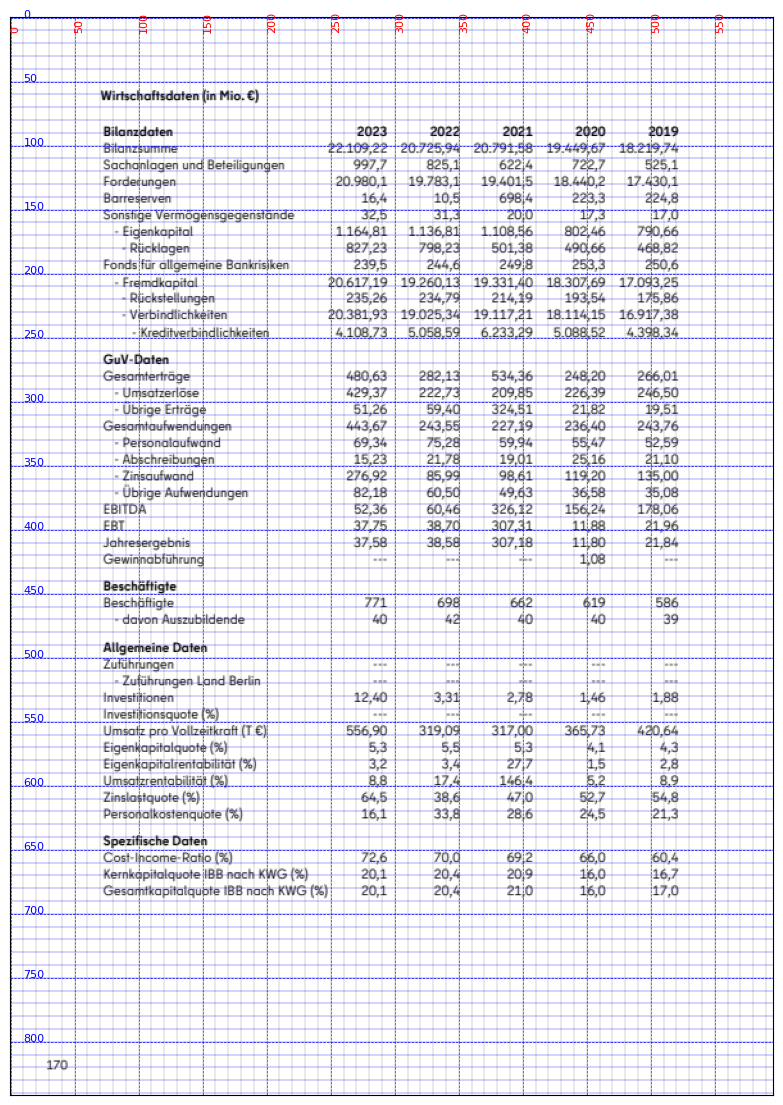

In [149]:
import matplotlib.pyplot as plt

p = 170
page = pdf[p-1]

# Render the page as an image (DPI 72 means 1 point = 1 pixel)
bitmap = page.render(scale=1)
img = bitmap.to_pil()

fig, ax = plt.subplots(figsize=(10, 14))
ax.imshow(img)

for x in np.arange(0, img.width, 10):
    ax.axvline(x, color='gray', linewidth=0.25, linestyle='-')
for y in np.arange(0, img.height, 10):
    ax.axhline(y, color='blue', linewidth=0.25, linestyle='-')

# Draw grid lines every 50 points (adjust as needed)
for x in np.arange(0, img.width, 50):
    ax.axvline(x, color='red', linewidth=0.5, linestyle='--')
    ax.text(x, 10, str(x), color='red', fontsize=8, rotation=90)
for y in np.arange(0, img.height, 50):
    ax.axhline(y, color='blue', linewidth=0.5, linestyle='--')
    ax.text(10, y, str(y), color='blue', fontsize=8)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Marker

In [1]:
from marker.converters.table import TableConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered
from marker.config.parser import ConfigParser

pdf_path = "bb_2024_gesamt.pdf"

config = {
    "paginate_output": True,
    "page_range": "33-262"
    }
config_parser = ConfigParser(config)

converter = TableConverter(
    config=config_parser.generate_config_dict(),
    artifact_dict=create_model_dict(),
)
rendered = converter(pdf_path)
text, _, images = text_from_rendered(rendered)

Loaded layout model s3://layout/2025_02_18 on device cpu with dtype torch.float32
Loaded texify model s3://texify/2025_02_18 on device cpu with dtype torch.float32
Loaded recognition model s3://text_recognition/2025_02_18 on device cpu with dtype torch.float32
Loaded table recognition model s3://table_recognition/2025_02_18 on device cpu with dtype torch.float32
Loaded detection model s3://text_detection/2025_02_28 on device cpu with dtype torch.float32
Loaded detection model s3://inline_math_detection/2025_02_24 on device cpu with dtype torch.float32


Running OCR Error Detection: 100%|██████████| 58/58 [00:54<00:00,  1.06it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 57/57 [14:02<00:00, 14.77s/it]


In [448]:
import re

pages = re.split(r'\{\d+\}-*\n+', text)

In [449]:
len(pages)

231

In [454]:
from IPython.display import display, Markdown

display(Markdown(pages[145]))

| Bilanzdaten                        | 2023  | 2022  | 2021  | 2020  | 2019  |
|------------------------------------|-------|-------|-------|-------|-------|
| Bilanzsumme                        | 2,65  | 2,03  | 1,10  | 1,05  | 0,97  |
| - Anlagevermögen                   | 1,61  | 1,05  | 0,81  | 0,71  | 0,63  |
| - Sachanlagen                      | 1,54  | 0,96  | 0,75  | 0,63  | 0,54  |
| - Finanzanlagen                    | ---   | ---   | ---   | ---   | ---   |
| - Umlaufvermögen                   | 0,99  | 0,98  | 0,29  | 0,34  | 0,22  |
| - Eigenkapital                     | 0,30  | 0,04  | 0,05  | 0,06  | ---   |
| - Rücklagen                        | ---   | ---   | ---   | ---   | ---   |
| - Sonderposten für Zuschüsse       | 1,61  | 1,05  | 0,81  | 0,71  | 0,63  |
| - Fremdkapital                     | 0,71  | 0,40  | 0,23  | 0,24  | 0,32  |
| - Rückstellungen                   | 0,11  | 0,10  | 0,09  | 0,08  | 0,12  |
| - Verbindlichkeiten                | 0,59  | 0,30  | 0,13  | 0,15  | 0,20  |
| - Kreditverbindlichkeiten          | ---   | ---   | ---   | ---   | ---   |
| GuV<br>-Daten                      |       |       |       |       |       |
| Gesamterträge                      | 11,99 | 9,95  | 9,19  | 8,74  | 9,13  |
| - Umsatzerlöse                     | 2,59  | 1,73  | 0,94  | 1,01  | 2,31  |
| - Übrige Erträge                   | 9,40  | 8,23  | 8,26  | 7,72  | 6,82  |
| Gesamtaufwendungen                 | 11,72 | 9,96  | 9,21  | 8,56  | 9,14  |
| - Personalaufwand                  | 6,06  | 5,92  | 5,65  | 5,36  | 4,90  |
| - Abschreibungen                   | 0,28  | 0,20  | 0,19  | 0,19  | 0,15  |
| - Zinsaufwand                      | ---   | ---   | ---   | ---   | ---   |
| - Übrige Aufwendungen              | 5,38  | 3,85  | 3,37  | 3,01  | 4,09  |
| EBITDA                             | 0,55  | 0,19  | 0,18  | 0,37  | 0,14  |
| EBT                                | 0,27  | -0,01 | -0,01 | 0,18  | -0,01 |
| Jahresergebnis                     | 0,27  | -0,01 | -0,01 | 0,18  | -0,01 |
| Gewinnabführung                    | ---   | ---   | ---   | ---   | ---   |
| Beschäftigte                       |       |       |       |       |       |
| Beschäftigte                       | 139   | 113   | 129   | 132   | 95    |
| - davon Auszubildende              | 2     | 4     | 4     | 5     | 6     |
|                                    |       |       |       |       |       |
| Allgemeine Daten                   |       |       |       |       |       |
| Zuführungen                        | 9,13  | 8,76  | 8,25  | 7,67  | 6,62  |
| - Zuführungen Land Berlin          | 8,01  | 8,53  | 7,92  | 7,45  | 6,51  |
| Investitionen                      | 0,84  | 0,44  | 0,30  | 0,27  | 0,07  |
| Investitionsquote (%)              | 52,2  | 42,2  | 36,6  | 38,6  | 11,5  |
| Umsatz pro Vollzeitkraft (T €)     | 18,61 | 15,30 | 7,25  | 7,66  | 24,27 |
| Eigenkapitalquote (%)              | 11,4  | 1,7   | 4,2   | 5,6   | ---   |
| Eigenkapitalrentabilität (%)       | 88,2  | -28,3 | -28,6 | 306,1 | ---   |
| Umsatzrentabilität (%)             | 10,3  | -0,6  | -1,4  | 17,7  | -0,6  |
| Zinslastquote (%)                  | ---   | ---   | ---   | ---   | ---   |
| Personalkostenquote (%)            | 234,1 | 342,3 | 603,9 | 529,4 | 212,4 |
| Spezifische Daten                  |       |       |       |       |       |
| Besucher/innen insgesamt (Tsd.)    | 662   | 501   | 357   | 315   | 955   |
| Besucher/innen KuJ (Tsd.)          | 513   | 378   | 302   | 245   | 765   |
| Besucher/innen Schwimmhalle (Tsd.) | 106   | 76    | 30    | 44    | 143   |
| Besucher/innen Badesee (Tsd.)      | 18    | 25    | 14    | 10    | 0     |
| Besucher/innen Landesmusikakade    | 31    | 21    | 12    | 15    | 47    |
| mie (Tsd.)                         |       |       |       |       |       |



In [19]:
pages[2]

'| Bilanzdaten                                   | 2023         | 2022         | 2021         | 2020         | 2019         |\n|-----------------------------------------------|--------------|--------------|--------------|--------------|--------------|\n| Bilanzsumme                                   | 28,16        | 29,07        | 28,41        | 20,97        | 15,30        |\n| - Anlagevermögen                              | 11,83        | 12,19        | 11,74        | 9,80         | 7,67         |\n| - Sachanlagen                                 | 0,20         | 0,29         | 0,44         | 0,47         | 0,48         |\n| - Finanzanlagen                               | 11,40        | 11,40        | 10,70        | 9,00         | 7,00         |\n| - Umlaufvermögen                              | 15,83        | 16,42        | 16,33        | 10,72        | 7,29         |\n| - Eigenkapital                                | 1,81         | 2,62         | 1,67         | 1,08         | 1,32   

In [102]:
with open("tables.md", "w", encoding="utf-8") as f:
    f.write(text)

In [447]:
with open("tables.md", "r", encoding="utf-8") as f:
    text = f.read()

In [415]:
import re
pages = re.split(r'\{\d+\}-*\n+', text)

In [416]:
pages_of_interest = [page for page in pages if "Bilanzdaten" in page]
len(pages_of_interest)

60

In [417]:
import pandas as pd
from io import StringIO
import numpy as np

# Assuming pages[2] contains a markdown table, extract it and convert to DataFrame

markdown_table = pages[2]

def markdown_table_to_df(markdown_table, verbose=False):
    df = pd.read_csv(StringIO(markdown_table), sep="|", engine="python", skipinitialspace=True)
    df = df.dropna(axis=1, how='all')

    df = df.dropna(axis=1, how='all')  # Drop empty columns if any
    df = df.dropna(axis=0, how='all')  # Drop empty rows if any
    df.columns = [col.strip() for col in df.columns]  # Clean column names
    df = df.map(lambda x: str(x).strip() if isinstance(x, str) else x) # Strip whitespace from all cells
    df = df[~df.apply(lambda row: all(re.fullmatch(r'-+', str(cell).strip()) for cell in row), axis=1)] # remove rows with all cells containing only dashes
    df.reset_index(drop=True, inplace=True)

    year_columns = [col for col in df.columns if str(col).strip().isdigit() and 1900 <= int(col) <= 2100]
    year_columns

    # Insert a new row at the top with the first column set to the first cell value, others as NaN
    first_col = df.columns[0]
    first_cell = df.columns[0]
    new_row = {col: (first_cell if col == first_col else np.nan) for col in df.columns}
    df = pd.concat([pd.DataFrame([new_row]), df], ignore_index=True)

    df.rename(columns={df.columns[0]: 'H3'}, inplace=True)

    # Find rows where all cells contain "<br>" and split them
    rows_with_br = df.apply(lambda row: all("<br>" in str(cell) for cell in row), axis=1)
    new_rows = []
    for idx, row in df.iterrows():
        if rows_with_br[idx]:
            before = [str(cell).split("<br>")[0].strip() for cell in row]
            after = [str(cell).split("<br>")[1].strip() if "<br>" in str(cell) else "" for cell in row]
            new_rows.append(pd.Series(before, index=df.columns))
            new_rows.append(pd.Series(after, index=df.columns))
        else:
            new_rows.append(row)

    df = pd.DataFrame(new_rows, columns=df.columns).reset_index(drop=True)

    # find top hierarchy entries
    mask = df.drop('H3', axis=1).isna().all(axis=1)
    col_h1 = [entry if bool else np.nan for entry, bool in zip(df['H3'], mask)]
    # Insert new column at position 1 with this value for all rows
    df.insert(0, 'H1', col_h1)
    df['H1'] = df['H1'].ffill()
    df = df.dropna(subset=year_columns, how='all')

    # find second hierarchy entries
    mask = ~df['H3'].str.startswith('-')
    col_h2 = [entry if bool else np.nan for entry, bool in zip(df['H3'], mask)]
    df.insert(1, 'H2', col_h2)
    df['H2'] = df['H2'].ffill()

    # missing value instead of "---"; missing means not applicable for company
    df = df.map(lambda x: np.nan if str(x).startswith('---') else x)

    # Convert the last 5 columns to numeric, using ',' as the decimal separator
    for col in year_columns:
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def split_dataframe(df, col_name='H1'):
    dfs_by_col_name = {h1: group.reset_index(drop=True) for h1, group in df.groupby(col_name)}
    return dfs_by_col_name

df = markdown_table_to_df(markdown_table)
len(df)

42

In [418]:
dfs_by_h1 = split_dataframe(df, col_name='H1')
dfs_by_h1

{'Allgemeine Daten':                  H1                              H2  \
 0  Allgemeine Daten                     Zuführungen   
 1  Allgemeine Daten                     Zuführungen   
 2  Allgemeine Daten                   Investitionen   
 3  Allgemeine Daten           Investitionsquote (%)   
 4  Allgemeine Daten  Umsatz pro Vollzeitkraft (T €)   
 5  Allgemeine Daten           Eigenkapitalquote (%)   
 6  Allgemeine Daten    Eigenkapitalrentabilität (%)   
 7  Allgemeine Daten          Umsatzrentabilität (%)   
 8  Allgemeine Daten               Zinslastquote (%)   
 9  Allgemeine Daten         Personalkostenquote (%)   
 
                                H3   2023    2022    2021   2020    2019  
 0                     Zuführungen  41.65   66.55   45.56  38.95   36.72  
 1       - Zuführungen Land Berlin  21.01   34.90   21.94  21.32   18.61  
 2                   Investitionen   0.05    0.21    0.55   0.43    0.20  
 3           Investitionsquote (%)  12.00   26.10   53.20  53.

In [419]:
def process_hierarchy_2_and_3(df):
    df_temp = df.copy()
    df_temp['H3'] = [str(h3).replace("- ", "") if h3 != h2 else np.nan for h2, h3 in zip(df_temp['H2'], df_temp['H3'])]
    return df_temp

df_temp = process_hierarchy_2_and_3(dfs_by_h1['Allgemeine Daten'])
df_temp

,H1,H2,H3,2023,2022,2021,2020,2019
0,Allgemeine Daten,Zuführungen,NaN,41.65,66.55,45.56,38.95,36.72
1,Allgemeine Daten,Zuführungen,Zuführungen Land Berlin,21.01,34.90,21.94,21.32,18.61
2,Allgemeine Daten,Investitionen,NaN,0.05,0.21,0.55,0.43,0.20
3,Allgemeine Daten,Investitionsquote (%),NaN,12.00,26.10,53.20,53.30,29.30
4,Allgemeine Daten,Umsatz pro Vollzeitkraft (T €),NaN,92.02,115.92,100.54,85.41,86.15
5,Allgemeine Daten,Eigenkapitalquote (%),NaN,6.40,9.00,5.90,5.10,8.60
6,Allgemeine Daten,Eigenkapitalrentabilität (%),NaN,-44.70,36.40,35.50,-22.90,-169.20
7,Allgemeine Daten,Umsatzrentabilität (%),NaN,-1.90,1.40,1.20,-0.60,-6.00
8,Allgemeine Daten,Zinslastquote (%),NaN,0.50,0.30,0.50,0.60,0.50
9,Allgemeine Daten,Personalkostenquote (%),NaN,73.20,52.80,63.10,74.60,77.60


In [420]:
df_temp = process_hierarchy_2_and_3(dfs_by_h1['Beschäftigte'])
df_temp

,H1,H2,H3,2023,2022,2021,2020,2019
0,Beschäftigte,Beschäftigte,NaN,458.0,577.0,482.0,466.0,434.0
1,Beschäftigte,Beschäftigte,davon Auszubildende,2.0,4.0,7.0,9.0,4.0


In [421]:
df_temp = process_hierarchy_2_and_3(dfs_by_h1['Spezifische Daten'])
df_temp

,H1,H2,H3,2023,2022,2021,2020,2019
0,Spezifische Daten,Dezentrale Bundesstatistiken (Anz.),NaN,227.0,232.0,233.0,223.0,214.0
1,Spezifische Daten,Dezentrale Bundesstatistiken (Anz.),darunter mit EU-Rechtsgrundlage (Anz.),77.0,82.0,83.0,88.0,84.0
2,Spezifische Daten,Länderstatistiken (Anz.),NaN,39.0,39.0,38.0,38.0,38.0
3,Spezifische Daten,Länderstatistiken (Anz.),davon Koordinierte Länderstatistiken (Anz.),14.0,14.0,14.0,14.0,14.0
4,Spezifische Daten,Länderstatistiken (Anz.),davon Generelle Länderstatistiken (Anz.),21.0,21.0,21.0,21.0,21.0
5,Spezifische Daten,Länderstatistiken (Anz.),davon Spezielle Länderstatistiken (Anz.),4.0,4.0,3.0,3.0,3.0


In [422]:
df_temp = process_hierarchy_2_and_3(dfs_by_h1['GuV-Daten'])
df_temp

,H1,H2,H3,2023,2022,2021,2020,2019
0,GuV-Daten,Gesamterträge,NaN,44.55,68.33,49.48,41.09,38.71
1,GuV-Daten,Gesamterträge,Umsatzerlöse,42.14,66.89,48.46,39.80,37.39
2,GuV-Daten,Gesamterträge,Übrige Erträge,2.40,1.44,1.02,1.29,1.31
3,GuV-Daten,Gesamtaufwendungen,NaN,45.36,67.37,48.89,41.33,40.93
4,GuV-Daten,Gesamtaufwendungen,Personalaufwand,30.85,35.29,30.58,29.69,29.00
5,GuV-Daten,Gesamtaufwendungen,Abschreibungen,0.41,0.45,0.35,0.29,0.33
6,GuV-Daten,Gesamtaufwendungen,Zinsaufwand,0.21,0.20,0.23,0.24,0.20
7,GuV-Daten,Gesamtaufwendungen,Übrige Aufwendungen,13.88,31.43,17.73,11.11,11.40
8,GuV-Daten,EBITDA,NaN,-0.64,1.06,1.14,0.26,-1.72
9,GuV-Daten,EBT,NaN,-0.81,0.95,0.59,-0.25,-2.23


In [423]:
def replace_spaces_with_pipe(match):
    return match.group(0).replace(' ', '|')

def fix_gruen_berlin_string(s):
    s = s.replace('<br>', '|')
    s = re.sub(r'((\\n)?(\|( )+)+)|((\\n)?(\|(-){4,})+\|)', '', s)
    s = re.sub(r'((- )?[a-zA-ZäöüßÄÖÜ \(\)%\.€]+(\|(([0-9]+(,[0-9]+)?)|-{3})){5})', r'\1|\n', s)
    s = re.sub(r'( ){2,}', '', s)
    s = re.sub(r'(\|\n){2,}', '', s)
    s = re.sub(r'([a-zA-ZäöüÄÖÜß]+)\|([a-zA-ZäöüÄÖÜß]+)', r'\1||||||\n\2', s)
    s = re.sub(r'(\n\n)', '\n', s)
    s = s.replace(' Bilanzdaten2023 2022 2021 2020 2019 |\n', '')
    s = re.sub(r'( (([0-9]+(,[0-9]+)?))){5}', replace_spaces_with_pipe, s)
    s = '| Bilanzdaten | 2023 | 2022 | 2021 | 2020 | 2019 |\n|----|----|----|----|----|----|\n'+s
    s = re.sub(r'(\|\n)((- )?[a-zA-ZäöüßÄÖÜ\(\)%\.€]+)', r'\1|\2', s)
    return s

s = pages_of_interest[30]
s_fixed = fix_gruen_berlin_string(s)
# Markdown(s_fixed)

In [425]:
def clean_page_text(page):
    page = page.replace('GuV<br>-Daten', 'GuV-Daten')
    return page

for idx, page in enumerate(pages_of_interest):
    try:
        try:
            page = clean_page_text(page)
            df = markdown_table_to_df(page)
        except Exception as e:
            page_fixed = fix_gruen_berlin_string(page)
            df = markdown_table_to_df(page_fixed, verbose=False)

        dfs_by_h1 = split_dataframe(df, col_name='H1')

        # check keys
        expected_keys = ['Allgemeine Daten', 'Beschäftigte', 'Bilanzdaten', 'GuV-Daten', 'Spezifische Daten']
        if not all(key in dfs_by_h1.keys() for key in expected_keys):
            missing_keys = [key for key in expected_keys if key not in dfs_by_h1.keys()]
            print(f"Page {idx} missing keys: {missing_keys}")

        unexpected_keys = [key for key in dfs_by_h1.keys() if key not in expected_keys]
        if unexpected_keys:
            print(f"Page {idx} unexpected keys: {unexpected_keys}")
        
        for h1, df_h1 in dfs_by_h1.items():
            match h1:
                case 'Allgemeine Daten':
                    df_temp = process_hierarchy_2_and_3(df_h1)
                    if df_temp.shape[0] != 10:
                        # print(f"Page {idx} - {h1}:\n", page)
                        # print(df_temp)
                        pass
                case 'Beschäftigte':
                    df_temp = process_hierarchy_2_and_3(df_h1)
                    if df_temp.shape[0] != 2:
                        # print(f"Page {idx} - {h1}:\n", page)
                        # print(df_temp)
                        pass
    except Exception as e:
        print(f"Error processing page {idx}: {e}")
        continue

Page 2 missing keys: ['Spezifische Daten']
Page 3 unexpected keys: ['(Tsd. m²)']
Page 4 missing keys: ['Allgemeine Daten', 'Beschäftigte', 'Bilanzdaten', 'GuV-Daten', 'Spezifische Daten']
Page 5 unexpected keys: ['(Anz.)']
Page 7 unexpected keys: ['Contracting (Mio. €)']
Page 9 missing keys: ['GuV-Daten']
Page 11 unexpected keys: ['(Mio. €)']
Page 12 missing keys: ['Allgemeine Daten']
Page 12 unexpected keys: ['muliert) (MW)']
Page 15 missing keys: ['Spezifische Daten']
Page 16 missing keys: ['Spezifische Daten']
Page 17 unexpected keys: ['schäftsbesorgung (Mio. €)']
Page 18 unexpected keys: ['Park (Anz.)']
Page 19 missing keys: ['Spezifische Daten']
Page 20 unexpected keys: ['Aufwendungen (€/m²)']
Page 23 missing keys: ['Spezifische Daten']
Page 28 unexpected keys: ['Aufwendungen (€/m²)']
Page 29 unexpected keys: ['Aufwendungen (€/m²)']
Page 33 unexpected keys: ['Aufwendungen (€/m²)']
Page 40 missing keys: ['Allgemeine Daten', 'Beschäftigte', 'Bilanzdaten', 'GuV-Daten', 'Spezifische D

In [426]:
Markdown(pages_of_interest[3])

| Bilanzdaten                          | 2023   | 2022   | 2021   | 2020   | 2019   |
|--------------------------------------|--------|--------|--------|--------|--------|
| Bilanzsumme                          | 96,67  | 96,41  | 94,10  | 98,16  | 101,00 |
| - Anlagevermögen                     | 72,75  | 74,61  | 75,38  | 77,49  | 81,08  |
| - Sachanlagen                        | 59,80  | 61,64  | 62,26  | 64,34  | 68,07  |
| - Finanzanlagen                      | 12,68  | 12,68  | 12,81  | 12,81  | 12,68  |
| - Umlaufvermögen                     | 23,84  | 21,76  | 18,68  | 20,60  | 19,87  |
| - Eigenkapital                       | 57,18  | 54,36  | 52,19  | 50,74  | 50,78  |
| - Rücklagen                          | 0,79   | 0,79   | 0,79   | 0,79   | 0,79   |
| - Sonderposten für Zuschüsse         | 7,28   | 8,60   | 9,95   | 11,40  | 13,03  |
| - Fremdkapital                       | 14,21  | 14,82  | 12,54  | 15,93  | 16,39  |
| - Rückstellungen                     | 10,92  | 10,77  | 8,19   | 9,54   | 9,07   |
| - Verbindlichkeiten                  | 3,29   | 4,05   | 4,36   | 6,39   | 7,33   |
| - Kreditverbindlichkeiten            | ---    | ---    | 0,87   | 1,72   | 2,54   |
| GuV<br>-Daten                        |        |        |        |        |        |
| Gesamterträge                        | 27,51  | 26,47  | 24,35  | 25,14  | 25,44  |
| - Umsatzerlöse                       | 22,94  | 22,60  | 20,52  | 21,25  | 21,45  |
| - Übrige Erträge                     | 4,57   | 3,87   | 3,83   | 3,88   | 3,99   |
| Gesamtaufwendungen                   | 24,69  | 24,30  | 22,90  | 23,71  | 22,79  |
| - Personalaufwand                    | 8,42   | 8,20   | 7,89   | 7,70   | 7,08   |
| - Abschreibungen                     | 4,56   | 4,57   | 4,75   | 5,34   | 5,29   |
| - Zinsaufwand                        | 0,10   | 0,08   | 0,14   | 0,21   | 0,24   |
| - Übrige Aufwendungen                | 11,62  | 11,44  | 10,13  | 10,46  | 10,18  |
| EBITDA                               | 7,63   | 7,39   | 6,86   | 6,69   | 8,82   |
| EBT                                  | 4,32   | 3,42   | 2,36   | 2,13   | 4,66   |
| Jahresergebnis                       | 2,82   | 2,17   | 1,45   | 1,42   | 2,65   |
| Gewinnabführung                      | ---    | ---    | ---    | ---    | 1,47   |
| Beschäftigte                         |        |        |        |        |        |
| Beschäftigte                         | 127    | 128    | 128    | 121    | 118    |
| - davon Auszubildende                | 9      | 9      | 9      | 7      | 3      |
| Allgemeine Daten                     |        |        |        |        |        |
| Zuführungen                          | ---    | ---    | ---    | ---    | ---    |
| - Zuführungen Land Berlin            | ---    | ---    | ---    | ---    | ---    |
| Investitionen                        | 2,90   | 3,94   | 2,64   | 1,67   | 5,19   |
| Investitionsquote (%)                | 4,8    | 6,4    | 4,2    | 2,6    | 7,6    |
| Umsatz pro Vollzeitkraft (T €)       | 180,66 | 176,57 | 160,35 | 175,65 | 181,79 |
|                                      |        |        |        |        |        |
| Eigenkapitalquote (%)                | 59,1   | 56,4   | 55,5   | 51,7   | 50,3   |
| Eigenkapitalrentabilität (%)         | 7,5    | 6,3    | 4,5    | 4,2    | 9,2    |
| Umsatzrentabilität (%)               | 18,8   | 15,1   | 11,5   | 10,0   | 21,7   |
| Zinslastquote (%)                    | 0,4    | 0,4    | 0,7    | 1,0    | 1,1    |
| Personalkostenquote (%)              | 36,7   | 36,3   | 38,4   | 36,2   | 33,0   |
| Spezifische Daten                    |        |        |        |        |        |
| Freilagerflächen vermietet (Tsd. m²) | 252    | 239    | 238    | 238    | 237    |
| Freilagerflächen eigenbewirtschaftet | 25     | 22     | 22     | 22     | 22     |
| (Tsd. m²)                            |        |        |        |        |        |
| Freilagerflächen Reserve (Tsd. m²)   | 20     | 34     | 35     | 35     | 33     |
| Gedeckter Lagerraum (Tsd. m²)        | 121    | 117    | 117    | 117    | 120    |
| Gütereing. Schiff (T t)              | 311    | 344    | 356    | 366    | 427    |
| Gütereing. Bahn (T t)                | 751    | 747    | 740    | 769    | 959    |
| Gütereing. Lkw (T t)                 | 971    | 1.212  | 1.204  | 1.007  | 896    |
| Güterausg. Schiff (T t)              | 139    | 212    | 144    | 311    | 339    |
| Güterausg. Bahn (T t)                | 351    | 444    | 456    | 518    | 496    |
| Güterausg. Lkw (T t)                 | 1.522  | 1.541  | 1.623  | 1.554  | 1.662  |



In [429]:
pprint(pages_of_interest[3])

('| Bilanzdaten                          | 2023   | 2022   | 2021   | 2020   | '
 '2019   |\n'
 '|--------------------------------------|--------|--------|--------|--------|--------|\n'
 '| Bilanzsumme                          | 96,67  | 96,41  | 94,10  | 98,16  | '
 '101,00 |\n'
 '| - Anlagevermögen                     | 72,75  | 74,61  | 75,38  | 77,49  | '
 '81,08  |\n'
 '| - Sachanlagen                        | 59,80  | 61,64  | 62,26  | 64,34  | '
 '68,07  |\n'
 '| - Finanzanlagen                      | 12,68  | 12,68  | 12,81  | 12,81  | '
 '12,68  |\n'
 '| - Umlaufvermögen                     | 23,84  | 21,76  | 18,68  | 20,60  | '
 '19,87  |\n'
 '| - Eigenkapital                       | 57,18  | 54,36  | 52,19  | 50,74  | '
 '50,78  |\n'
 '| - Rücklagen                          | 0,79   | 0,79   | 0,79   | 0,79   | '
 '0,79   |\n'
 '| - Sonderposten für Zuschüsse         | 7,28   | 8,60   | 9,95   | 11,40  | '
 '13,03  |\n'
 '| - Fremdkapital                       | 14,21  | 14